## 0. Install and Import Dependencies

In [63]:
!pip install easyocr
!pip install imutils

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [64]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import imutils
import easyocr

## 1. Read in Image, Grayscale and Blur

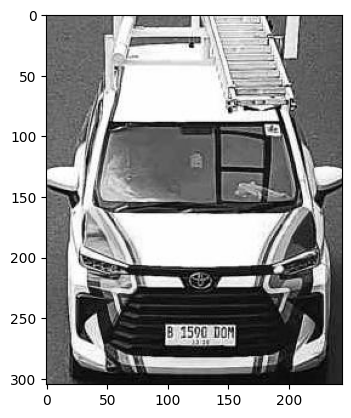

In [65]:
img = cv2.imread('image7.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))

## 2. Apply filter and find edges for localization

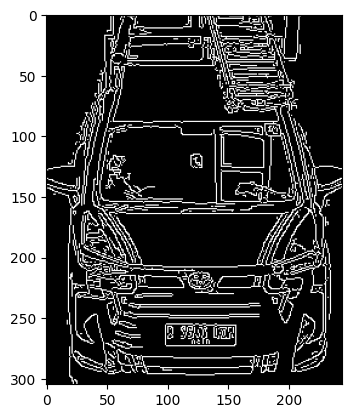

In [66]:
bfilter = cv2.bilateralFilter(gray, 11, 17, 17) #Noise reduction
edged = cv2.Canny(bfilter, 30, 200) #Edge detection
plt.imshow(cv2.cvtColor(edged, cv2.COLOR_BGR2RGB))

## 3. Find Contours and Apply Mask

In [67]:
keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(keypoints)
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

In [68]:
location = None  # Initialize the location variable

for contour in contours:
    # Approximate the contour with a polygon
    approx = cv2.approxPolyDP(contour, epsilon=0.02 * cv2.arcLength(contour, True), closed=True)
    
    # Check if the approximated polygon has 4 vertices (quadrilateral)
    if len(approx) == 4:
        location = approx
        break  # Exit the loop once the first quadrilateral is found

# Check if a location was found
if location is not None:
    print("Found a quadrilateral:")
    print(location)
else:
    print("No quadrilateral found.")


Found a quadrilateral:
[[[ 98 256]]

 [[ 99 273]]

 [[156 272]]

 [[156 256]]]


In [69]:
location

array([[[ 98, 256]],

       [[ 99, 273]],

       [[156, 272]],

       [[156, 256]]], dtype=int32)

In [70]:
mask = np.zeros(gray.shape, np.uint8)
new_image = cv2.drawContours(mask, [location], 0,255, -1)
new_image = cv2.bitwise_and(img, img, mask=mask)

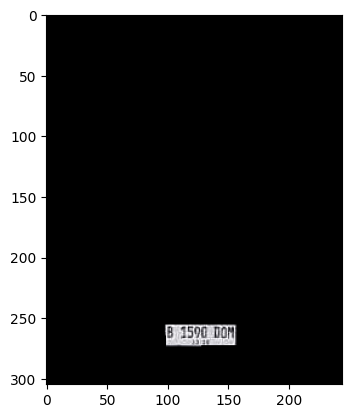

In [71]:
plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))

In [72]:
(x,y) = np.where(mask==255)
(x1, y1) = (np.min(x), np.min(y))
(x2, y2) = (np.max(x), np.max(y))
cropped_image = gray[x1:x2+1, y1:y2+1]

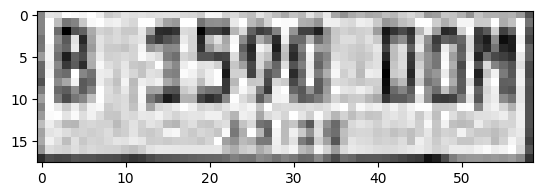

In [73]:
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))

## 4. Use Easy OCR To Read Text

In [74]:
reader = easyocr.Reader(['en'])
result = reader.readtext(cropped_image)
result

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


[([[np.int32(11), 0],
   [59, 0],
   [59, np.int32(15)],
   [np.int32(11), np.int32(15)]],
  '1500 DON',
  np.float64(0.3315482762403329))]

## 5. Render Result

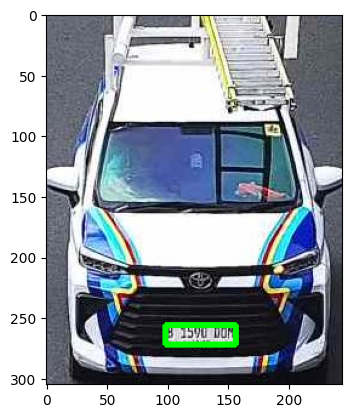

In [75]:
text = result[0][-2]
font = cv2.FONT_HERSHEY_SIMPLEX
res = cv2.putText(img, text=text, org=(approx[0][0][0], approx[1][0][1]+60), fontFace=font, fontScale=1, color=(0,255,0), thickness=2, lineType=cv2.LINE_AA)
res = cv2.rectangle(img, tuple(approx[0][0]), tuple(approx[2][0]), (0,255,0),3)
plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))